# Exploration of sources of sequencing error
## AIM:
Incorporate observations described in 1.1 to patient data. Specifically:
1. See the efficacy of 1.5% frequency cutoff,
2. Explore the need for updating locus filtering,
3. Check need for coverage filtering.

## APPROACH:
Re-plot some of the plots from 1.1 on patient data.

## DATA WRANGLING
I have used the following two scripts to process the data for preliminary exploration. These SNPs are not yet annotated.

>parse_patient_BASIC.py

>parse_patient_FINAL.py

The output of these scripts are:
- 1_BASIC.csv
- 1_BASIC.pkl
- 1_FINAL.csv
- 1_FINAL.pkl


## ANALYSIS
Start by setting up the kernel

In [1]:
#Python core packages
from collections import Counter
import string
import pickle
import datetime
import warnings
warnings.filterwarnings("ignore")

#Additional Python packages
import tqdm

#Scientific packages
from scipy import stats as ss
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import utils as sku
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

mpl.rcParams['font.family']='Arial'
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

In [2]:
#LOAD DATA
PATIENTS_BASIC = pd.read_csv('../data/interim/1_BASIC.csv', index_col=0)
PATIENTS_FINAL = pd.read_csv('../data/interim/1_FINAL.csv', index_col=0)
DF_COLONY = pd.read_csv('../data/interim/1_colony_sequencing.csv', index_col=0)
DF_ART = pd.read_csv('../data/interim/1_ART_simulation.csv', index_col=0)

## BASIC PIPELINE OUTPUT

### Regions of high variability
In the first instance I am interested in:

1. Where are the mutations?
2. What is the frequency distribution of all vSNPs?

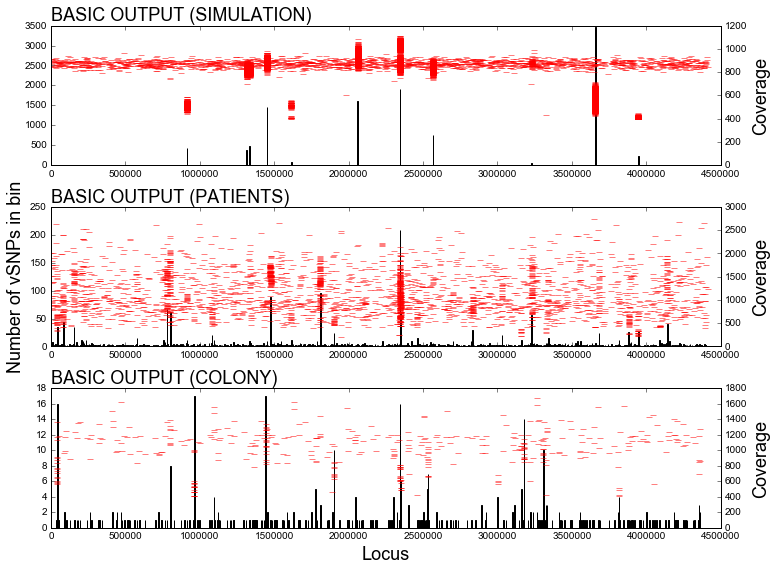

In [4]:
plt.figure(figsize=(12,9))
plt.subplot(311)
plt.title('BASIC OUTPUT (SIMULATION)', loc='left', size=18)
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.twinx()
plt.plot(list(DF_ART[(DF_ART.STAGE=='BASIC')].LOCUS), 
         list(DF_ART[(DF_ART.STAGE=='BASIC')].COVERAGE), 'r_')
plt.ylim(0,1200)
plt.ylabel('Coverage', size=18)

plt.subplot(312)
plt.title('BASIC OUTPUT (PATIENTS)', loc='left', size=18)
plt.hist(list(PATIENTS_BASIC.LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.ylabel('Number of vSNPs in bin', size=18)
plt.twinx()
plt.plot(list(PATIENTS_BASIC.LOCUS), 
         list(PATIENTS_BASIC.COVERAGE), 'r_')
plt.ylim(0,3000)
plt.ylabel('Coverage', size=18)

plt.subplot(313)
plt.title('BASIC OUTPUT (COLONY)', loc='left', size=18)
plt.hist(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.xlabel('Locus', size=18)
plt.twinx()
plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].LOCUS), 
         list(DF_COLONY[(DF_COLONY.STAGE=='BASIC')].COVERAGE), 'r_')
plt.ylim(0,1800)
plt.ylabel('Coverage', size=18)

plt.subplots_adjust(hspace=0.3)

It's difficult to judge this, as I've collated data from 48 samples, each with a different overall coverage. Needs a revisit.

In terms of data shape, the regions of high variablity different among the three datasets. Let's check the effect of filtering on this.

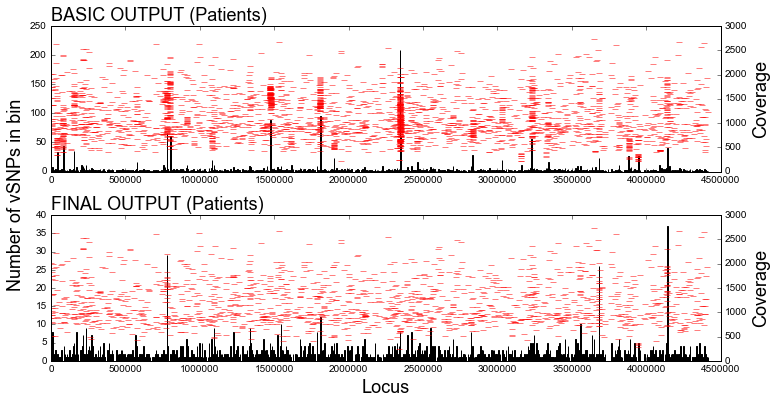

In [5]:
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.title('BASIC OUTPUT (Patients)', loc='left', size=18)
plt.hist(list(PATIENTS_BASIC.LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.ylabel('Number of vSNPs in bin', size=18, horizontalalignment='right')
plt.twinx()
plt.plot(list(PATIENTS_BASIC.LOCUS), 
         list(PATIENTS_BASIC.COVERAGE), 'r_')
plt.ylim(0,3000)
plt.ylabel('Coverage', size=18)
plt.subplot(212)
plt.title('FINAL OUTPUT (Patients)', loc='left', size=18)
plt.hist(list(PATIENTS_FINAL.LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.xlabel('Locus', size=18)
plt.twinx()
plt.plot(list(PATIENTS_FINAL.LOCUS), 
         list(PATIENTS_FINAL.COVERAGE), 'r_')
plt.ylim(0,3000)
plt.ylabel('Coverage', size=18)

plt.subplots_adjust(hspace=0.3)

Filtering does a decent job at getting rid of highly variable regions. There are a couple of exceptions, namely one in the 4.1M region (this is glpK large number of SNPs in one of the patients). Then there are two more peaks one around 0.7M and one around 3.7M. However they do not seem to have coverage issues. I would need a null distribution of reads. Illumina reckons that the distribution is "Possion-like" whatever that means. 

>http://www.illumina.com/science/education/sequencing-coverage.html

So how well does the Poisson fit? Or a Gamma? Or a log-gamma?

Use the simulation data...

(array([ 0.   ,  0.002,  0.004,  0.006,  0.008,  0.01 ,  0.012,  0.014,
         0.016]), <a list of 9 Text yticklabel objects>)

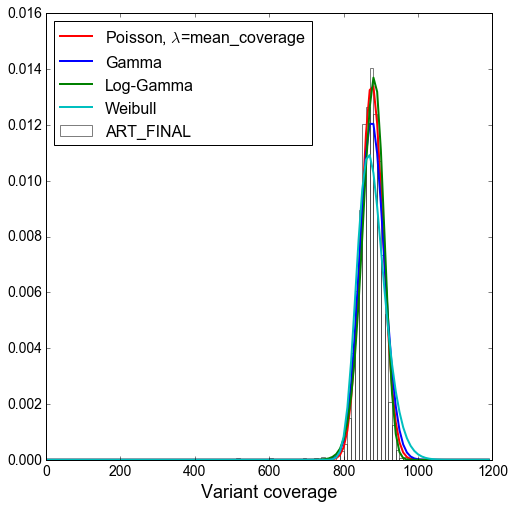

In [122]:
#Define a Poisson distribution centred on the mean coverage for the samples.
ART_FINAL_POISSON = ss.poisson(np.mean(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE)))
g_a,g_b,g_c = ss.gamma.fit(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE))
ART_FINAL_GAMMA = ss.gamma(g_a,g_b,g_c) 
g_a,g_b,g_c = ss.loggamma.fit(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE))
ART_FINAL_LGAMMA = ss.loggamma(g_a,g_b,g_c) 
w_a,w_b,w_c,w_d = ss.exponweib.fit(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE))
ART_FINAL_WEIBULL = ss.exponweib(w_a,w_b,w_c,w_d)

plt.figure(figsize=(8,8))
plt.hist(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE),
         bins=np.arange(0,1200,10), normed=True, 
         color='white', label='ART_FINAL', alpha=0.5)
plt.plot(np.arange(0,1200,10), ART_FINAL_POISSON.pmf(np.arange(-5,1195,10)), 
         'r-',lw=2, label=r'Poisson, $\lambda$=mean_coverage')
plt.plot(np.arange(0,1200,10), ART_FINAL_GAMMA.pdf(np.arange(-5,1195,10)), 
         'b-',lw=2, label=r'Gamma')
plt.plot(np.arange(0,1200,10), ART_FINAL_LGAMMA.pdf(np.arange(-5,1195,10)), 
         'g-',lw=2, label=r'Log-Gamma')
plt.plot(np.arange(0,1200,10), ART_FINAL_WEIBULL.pdf(np.arange(-5,1195,10)), 
         'c-',lw=2, label=r'Weibull')
plt.legend(loc=2, fontsize=16)
plt.xlabel('Variant coverage', size=18)
plt.xticks(size=14)
plt.yticks(size=14)

This looks remarkably close! Let's check the statistics for this. I'll make a QQ-plot for the poisson, do a $\chi^2$ test as well as check the mean and variance by re-sampling (in Poisson: $\lambda=\mu=\sigma$).

Bland-Altman residue T-test p-value: 2.89e-06
Chi2 test (for nonzero histogram bins) p-value: 2.34e-04


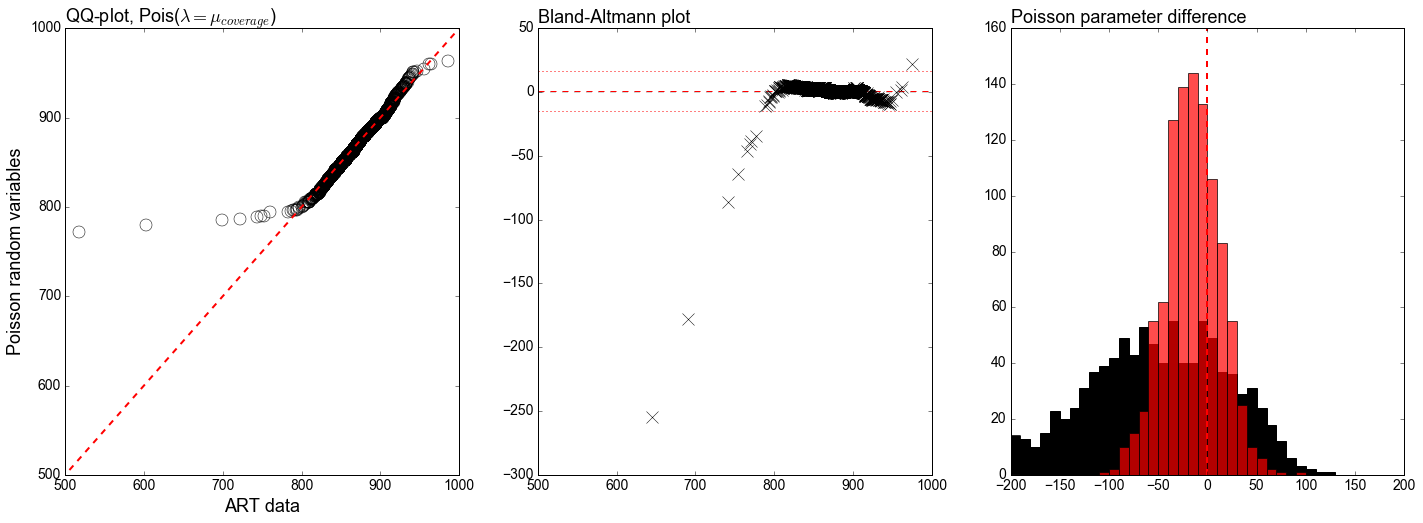

In [114]:
POIS_RANDOM = np.array(sorted(ART_FINAL_POISSON.rvs(1936, random_state=42))) #we have 1936 observations in ART
ART_COVERAGE = np.array(sorted(list(DF_ART[(DF_ART.STAGE=='FINAL')].COVERAGE)))
#Get histograms for each
ART_HIST = np.histogram(ART_COVERAGE, bins=np.arange(0,1200,10))[0]
POIS_ART_HIST = np.histogram(POIS_RANDOM, bins=np.arange(0,1200,10))[0]
#Get positions where both histograms have positive values.
NON_ZERO_VALUES = np.where((ART_HIST*POIS_ART_HIST)>0)

plt.figure(figsize=(24,8))
plt.subplot(131)
#plt.plot(ART_COVERAGE[np.arange(0,1936,20)],POIS_RANDOM[np.arange(0,1936,20)], 'wo', ms=12)
plt.plot(ART_COVERAGE,POIS_RANDOM, 'wo', mfc='none', ms=12)
plt.plot([0,2000], [0,2000], 'r--', lw=2)
plt.xlabel('ART data',size=18)
plt.ylabel('Poisson random variables',size=18)
plt.title(r'QQ-plot, Pois($\lambda=\mu_{coverage}$)',size=18, loc='left')
plt.xlim(500,1000)
plt.ylim(500,1000)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(132)
#plt.plot((ART_HIST+POIS_ART_HIST)/2,ART_HIST-POIS_ART_HIST, 'kx', ms=12)
plt.plot((ART_COVERAGE+POIS_RANDOM)/2,ART_COVERAGE-POIS_RANDOM, 'kx', ms=12)
plt.hlines(0,500,1000, linestyles='dashed', lw=2, colors='lightgrey')
plt.hlines(np.mean(ART_COVERAGE-POIS_RANDOM),500,1000, linestyles='dashed', colors='red')
plt.hlines(np.mean(ART_COVERAGE-POIS_RANDOM)+(1.96*np.std(ART_COVERAGE-POIS_RANDOM)),
           500,1000, linestyles='dotted', colors='red')
plt.hlines(np.mean(ART_COVERAGE-POIS_RANDOM)-(1.96*np.std(ART_COVERAGE-POIS_RANDOM)),
           500,1000, linestyles='dotted', colors='red')
plt.title(r'Bland-Altmann plot',size=18, loc='left')
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(133)
pois_diff, sample_diff = [], []
for x in range(1000):
    S = sku.resample(ART_COVERAGE)
    P = sku.resample(POIS_RANDOM)
    pois_diff.append(np.mean(P)-np.var(P))
    sample_diff.append(np.mean(S)-np.var(S))
    
#plt.plot((ART_HIST+POIS_ART_HIST)/2,ART_HIST-POIS_ART_HIST, 'kx', ms=12)
plt.hist(sample_diff, bins=np.arange(-200,200,10), color='black', label='ART_data')
plt.hist(pois_diff, bins=np.arange(-200,200,10), color='red', label='POISSON_random', alpha=0.7)
plt.title(r'Poisson parameter difference',size=18, loc='left')
plt.vlines(0,0,160,linestyles='dashed',colors='red',lw=2)
plt.xticks(size=14)
plt.yticks(size=14)

#print('Bland-Altmann residue T-test p-value:{}'.format(ss.ttest_1samp(ART_HIST-POIS_ART_HIST,0)[1]))
print('Bland-Altman residue T-test p-value: {:.2e}'.format(ss.ttest_1samp(ART_COVERAGE-POIS_RANDOM,0)[1]))
print('Chi2 test (for nonzero histogram bins) p-value: {:.2e}'.format(ss.chisquare(ART_HIST[NON_ZERO_VALUES], 
                                                                             POIS_ART_HIST[NON_ZERO_VALUES])[1]))


OK, this is not a Poisson distribution. What about a gamma?

Bland-Altman residue T-test p-value: 6.54e-11
Chi2 test (for nonzero histogram bins) p-value: 4.71e-10


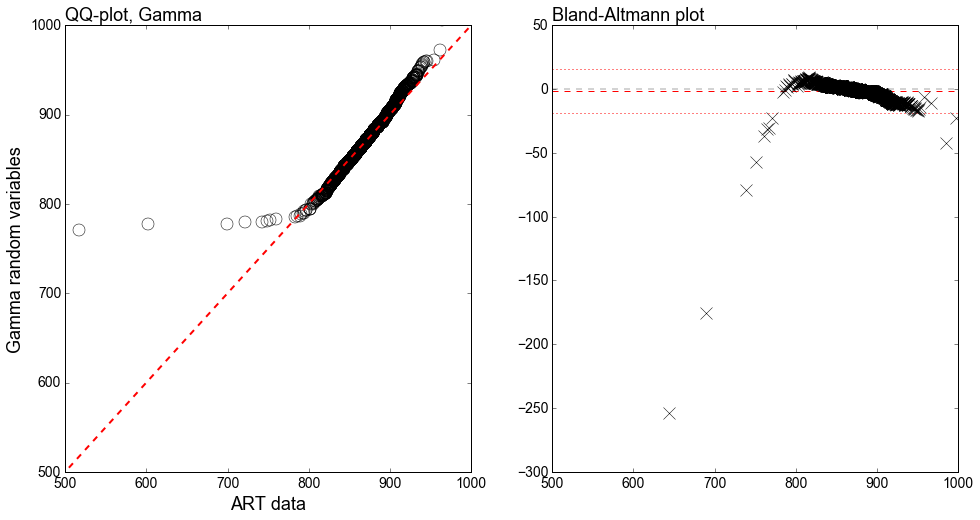

In [80]:
GAMMA_RANDOM = np.array(sorted(ART_FINAL_GAMMA.rvs(len(ART_COVERAGE), 
                                                   random_state=42))) #we have 1936 observations in ART

GAMMA_ART_HIST = np.histogram(GAMMA_RANDOM, bins=np.arange(0,1200,10))[0]
#Get positions where both histograms have positive values.
NON_ZERO_VALUES = np.where((ART_HIST*GAMMA_ART_HIST)>0)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(ART_COVERAGE,GAMMA_RANDOM, 'wo', mfc='none', ms=12)
plt.plot([0,2000], [0,2000], 'r--', lw=2)
plt.xlabel('ART data',size=18)
plt.ylabel('Gamma random variables',size=18)
plt.title(r'QQ-plot, Gamma',size=18, loc='left')
plt.xlim(500,1000)
plt.ylim(500,1000)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(122)
plt.plot((ART_COVERAGE+GAMMA_RANDOM)/2,ART_COVERAGE-GAMMA_RANDOM, 'kx', ms=12)
plt.hlines(0,500,1000, linestyles='dashed', lw=2, colors='lightgrey')
plt.hlines(np.mean(ART_COVERAGE-GAMMA_RANDOM),500,1000, linestyles='dashed', colors='red')
plt.hlines(np.mean(ART_COVERAGE-GAMMA_RANDOM)+(1.96*np.std(ART_COVERAGE-GAMMA_RANDOM)),
           500,1000, linestyles='dotted', colors='red')
plt.hlines(np.mean(ART_COVERAGE-GAMMA_RANDOM)-(1.96*np.std(ART_COVERAGE-GAMMA_RANDOM)),
           500,1000, linestyles='dotted', colors='red')
plt.title(r'Bland-Altmann plot',size=18, loc='left')
plt.xticks(size=14)
plt.yticks(size=14)

#print('Bland-Altmann residue T-test p-value:{}'.format(ss.ttest_1samp(ART_HIST-POIS_ART_HIST,0)[1]))
print('Bland-Altman residue T-test p-value: {:.2e}'.format(ss.ttest_1samp(ART_COVERAGE-GAMMA_RANDOM,0)[1]))
print('Chi2 test (for nonzero histogram bins) p-value: {:.2e}'.format(ss.chisquare(ART_HIST[NON_ZERO_VALUES], 
                                                                             GAMMA_ART_HIST[NON_ZERO_VALUES])[1]))


Not a gamma either. I wonder whether this improves if I cut out the outliers? Could I use deviation from the poisson as a metric for filtering?

Bland-Altman residue T-test p-value: 5.13e-13
Chi2 test (for nonzero histogram bins) p-value: 2.01e-06


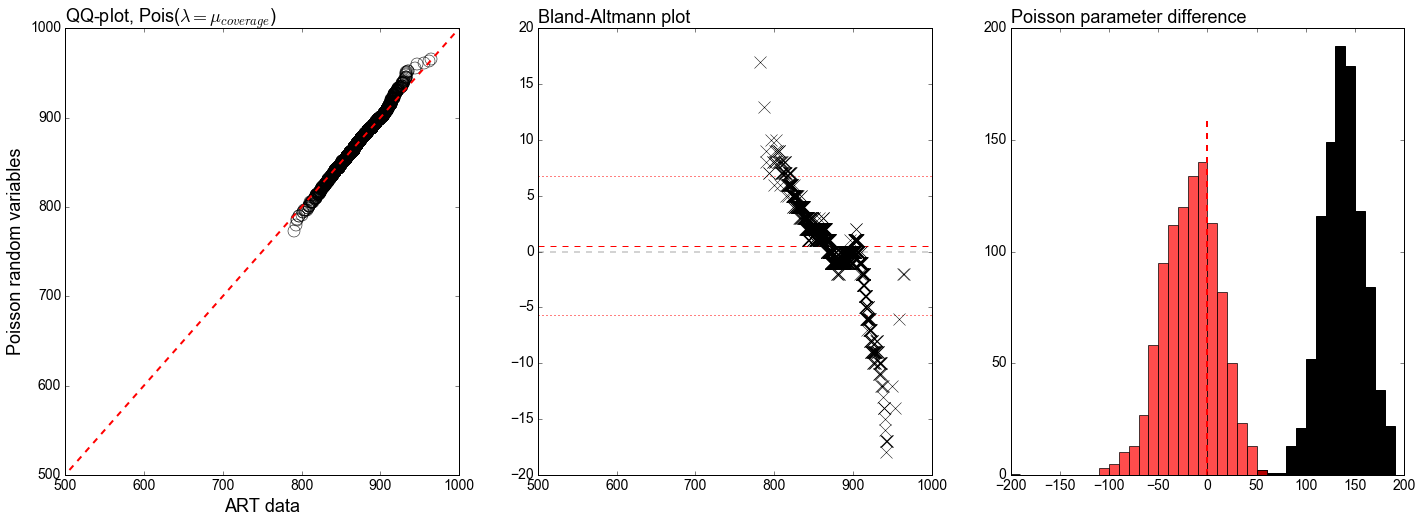

In [94]:
DIFFERENCE_MEAN = np.mean(POIS_RANDOM-ART_COVERAGE)
DIFFERENCE_STD = np.std(POIS_RANDOM-ART_COVERAGE)
LOWER, UPPER = DIFFERENCE_MEAN-DIFFERENCE_STD, DIFFERENCE_MEAN+DIFFERENCE_STD

ART_KEEP = [ind for (ind,val) in enumerate(POIS_RANDOM-ART_COVERAGE) if val < UPPER and val > LOWER]

ART_COVERAGE = ART_COVERAGE[ART_KEEP]
ART_SUBSET_POISSON = ss.poisson(np.mean(ART_COVERAGE))
POIS_RANDOM = np.array(sorted(ART_SUBSET_POISSON.rvs(len(ART_COVERAGE), 
                                                    random_state=42))) #we have 1936 observations in ART


#Get histograms for each
ART_HIST = np.histogram(ART_COVERAGE, bins=np.arange(0,1200,10))[0]
POIS_ART_HIST = np.histogram(POIS_RANDOM, bins=np.arange(0,1200,10))[0]
#Get positions where both histograms have positive values.
NON_ZERO_VALUES = np.where((ART_HIST*POIS_ART_HIST)>0)

plt.figure(figsize=(24,8))
plt.subplot(131)
#plt.plot(ART_COVERAGE[np.arange(0,1936,20)],POIS_RANDOM[np.arange(0,1936,20)], 'wo', ms=12)
plt.plot(ART_COVERAGE,POIS_RANDOM, 'wo', mfc='none', ms=12)
plt.plot([0,2000], [0,2000], 'r--', lw=2)
plt.xlabel('ART data',size=18)
plt.ylabel('Poisson random variables',size=18)
plt.title(r'QQ-plot, Pois($\lambda=\mu_{coverage}$)',size=18, loc='left')
plt.xlim(500,1000)
plt.ylim(500,1000)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(132)
#plt.plot((ART_HIST+POIS_ART_HIST)/2,ART_HIST-POIS_ART_HIST, 'kx', ms=12)
plt.plot((ART_COVERAGE+POIS_RANDOM)/2,ART_COVERAGE-POIS_RANDOM, 'kx', ms=12)
plt.hlines(0,500,1000, linestyles='dashed', lw=2, colors='lightgrey')
plt.hlines(np.mean(ART_COVERAGE-POIS_RANDOM),500,1000, linestyles='dashed', colors='red')
plt.hlines(np.mean(ART_COVERAGE-POIS_RANDOM)+(1.96*np.std(ART_COVERAGE-POIS_RANDOM)),
           500,1000, linestyles='dotted', colors='red')
plt.hlines(np.mean(ART_COVERAGE-POIS_RANDOM)-(1.96*np.std(ART_COVERAGE-POIS_RANDOM)),
           500,1000, linestyles='dotted', colors='red')
plt.title(r'Bland-Altmann plot',size=18, loc='left')
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(133)
pois_diff, sample_diff = [], []
for x in range(1000):
    S = sku.resample(ART_COVERAGE)
    P = sku.resample(POIS_RANDOM)
    pois_diff.append(np.mean(P)-np.var(P))
    sample_diff.append(np.mean(S)-np.var(S))
    
#plt.plot((ART_HIST+POIS_ART_HIST)/2,ART_HIST-POIS_ART_HIST, 'kx', ms=12)
plt.hist(sample_diff, bins=np.arange(-200,200,10), color='black', label='ART_data')
plt.hist(pois_diff, bins=np.arange(-200,200,10), color='red', label='POISSON_random', alpha=0.7)
plt.title(r'Poisson parameter difference',size=18, loc='left')
plt.vlines(0,0,160,linestyles='dashed',colors='red',lw=2)
plt.xticks(size=14)
plt.yticks(size=14)

#print('Bland-Altmann residue T-test p-value:{}'.format(ss.ttest_1samp(ART_HIST-POIS_ART_HIST,0)[1]))
print('Bland-Altman residue T-test p-value: {:.2e}'.format(ss.ttest_1samp(ART_COVERAGE-POIS_RANDOM,0)[1]))
print('Chi2 test (for nonzero histogram bins) p-value: {:.2e}'.format(ss.chisquare(ART_HIST[NON_ZERO_VALUES], 
                                                                             POIS_ART_HIST[NON_ZERO_VALUES])[1]))


This gets rid of the kinks, but the variance is too little (see how $\mu-\sigma $ is offset by about 150...).

Bland-Altman residue T-test p-value: 5.46e-06
Chi2 test (for nonzero histogram bins) p-value: 1.37e-03


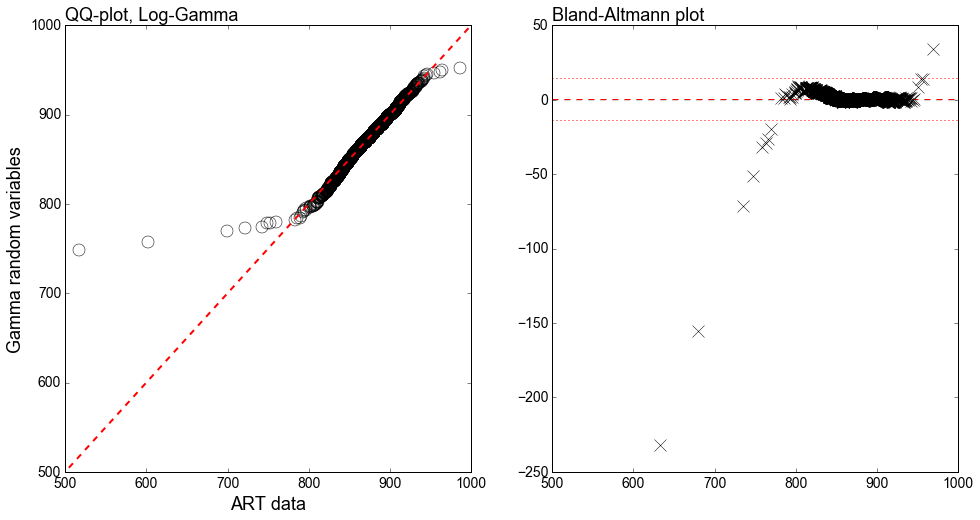

In [100]:
LGAMMA_RANDOM = np.array(sorted(ART_FINAL_LGAMMA.rvs(len(ART_COVERAGE), 
                                                   random_state=4223))) #we have 1936 observations in ART

LGAMMA_ART_HIST = np.histogram(LGAMMA_RANDOM, bins=np.arange(0,1200,10))[0]
#Get positions where both histograms have positive values.
NON_ZERO_VALUES = np.where((ART_HIST*LGAMMA_ART_HIST)>0)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(ART_COVERAGE,LGAMMA_RANDOM, 'wo', mfc='none', ms=12)
plt.plot([0,2000], [0,2000], 'r--', lw=2)
plt.xlabel('ART data',size=18)
plt.ylabel('Gamma random variables',size=18)
plt.title(r'QQ-plot, Log-Gamma',size=18, loc='left')
plt.xlim(500,1000)
plt.ylim(500,1000)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(122)
plt.plot((ART_COVERAGE+LGAMMA_RANDOM)/2,ART_COVERAGE-LGAMMA_RANDOM, 'kx', ms=12)
plt.hlines(0,500,1000, linestyles='dashed', lw=2, colors='lightgrey')
plt.hlines(np.mean(ART_COVERAGE-LGAMMA_RANDOM),500,1000, linestyles='dashed', colors='red')
plt.hlines(np.mean(ART_COVERAGE-LGAMMA_RANDOM)+(1.96*np.std(ART_COVERAGE-LGAMMA_RANDOM)),
           500,1000, linestyles='dotted', colors='red')
plt.hlines(np.mean(ART_COVERAGE-LGAMMA_RANDOM)-(1.96*np.std(ART_COVERAGE-LGAMMA_RANDOM)),
           500,1000, linestyles='dotted', colors='red')
plt.title(r'Bland-Altmann plot',size=18, loc='left')
plt.xticks(size=14)
plt.yticks(size=14)

#print('Bland-Altmann residue T-test p-value:{}'.format(ss.ttest_1samp(ART_HIST-POIS_ART_HIST,0)[1]))
print('Bland-Altman residue T-test p-value: {:.2e}'.format(ss.ttest_1samp(ART_COVERAGE-LGAMMA_RANDOM,0)[1]))
print('Chi2 test (for nonzero histogram bins) p-value: {:.2e}'.format(ss.chisquare(ART_HIST[NON_ZERO_VALUES], 
                                                                             LGAMMA_ART_HIST[NON_ZERO_VALUES])[1]))

Overall it looks like either a Poisson or Log-Gamma fit the best. <strong>The distribution of coverages does not actually belong to either class (!)</strong> but the approximation may be worth examining especially the Poisson.

One option would be to:
1. Derive mean coverage from a sentinel genomic region,
2. Identify cutoff values for coverage, using the Bland-Altman approach,
3. Apply coverage cutoffs to filter.

ALITER
1a. Perform step 1 on all FINAL SNPs... which is basically what I've done above?
1b. Determine the maximum based on Kernel Density estimation...

Test on ART_BASIC - using above cutoffs?

Include from 964 to 789


(array([ 0.   ,  0.005,  0.01 ,  0.015,  0.02 ,  0.025,  0.03 ]),
 <a list of 7 Text yticklabel objects>)

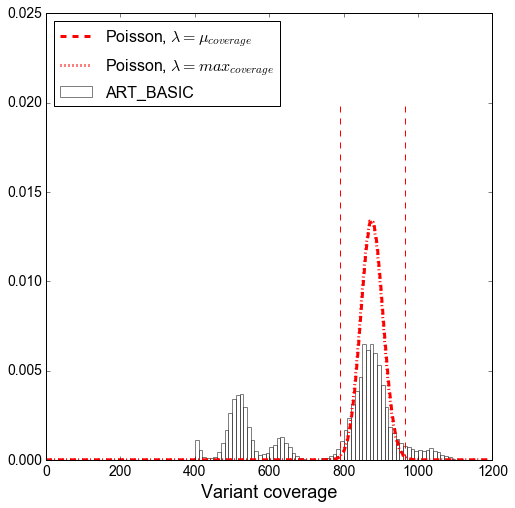

In [125]:
DIFFERENCE_MEAN = np.mean(POIS_RANDOM-ART_COVERAGE)
DIFFERENCE_STD = np.std(POIS_RANDOM-ART_COVERAGE)
LOWER, UPPER = DIFFERENCE_MEAN-DIFFERENCE_STD, DIFFERENCE_MEAN+DIFFERENCE_STD

UPPER_CUTOFF = max(ART_COVERAGE[np.where((ART_COVERAGE-POIS_RANDOM)<UPPER)])
LOWER_CUTOFF = min(ART_COVERAGE[np.where((ART_COVERAGE-POIS_RANDOM)>LOWER)])

print('Include from {} to {}'.format(UPPER_CUTOFF, LOWER_CUTOFF))

ART_KDE = ss.kde.gaussian_kde(list(DF_ART[(DF_ART.STAGE=='BASIC')].COVERAGE))
KDE_MAX = np.arange(2000)[np.argmax(ART_KDE.pdf(np.arange(2000)))]



plt.figure(figsize=(8,8))
plt.hist(list(DF_ART[(DF_ART.STAGE=='BASIC')].COVERAGE),
         bins=np.arange(0,1200,10), normed=True, 
         color='white', label='ART_BASIC', alpha=0.5)
plt.plot(np.arange(0,1200,10), ART_FINAL_POISSON.pmf(np.arange(-5,1195,10)), 
         'r--',lw=3, label=r'Poisson, $\lambda=\mu_{coverage}$')
plt.plot(np.arange(0,1200,10), ss.poisson(KDE_MAX).pmf(np.arange(-5,1195,10)), 
         'r:',lw=3, label=r'Poisson, $\lambda=max_{coverage}$')
plt.vlines(UPPER_CUTOFF, 0, 0.02, linestyles='dashed', colors='red')
plt.vlines(LOWER_CUTOFF, 0, 0.02, linestyles='dashed', colors='red')
plt.legend(loc=2, fontsize=16)
plt.xlabel('Variant coverage', size=18)
plt.xticks(size=14)
plt.yticks(size=14)

In [119]:
DF_ART['COVERAGE_CUT'] = [int(x<LOWER_CUTOFF or x>UPPER_CUTOFF) for x in DF_ART.COVERAGE]

(array([ 0.004,  0.006,  0.008,  0.01 ,  0.012,  0.014,  0.016,  0.018,
         0.02 ]), <a list of 9 Text yticklabel objects>)

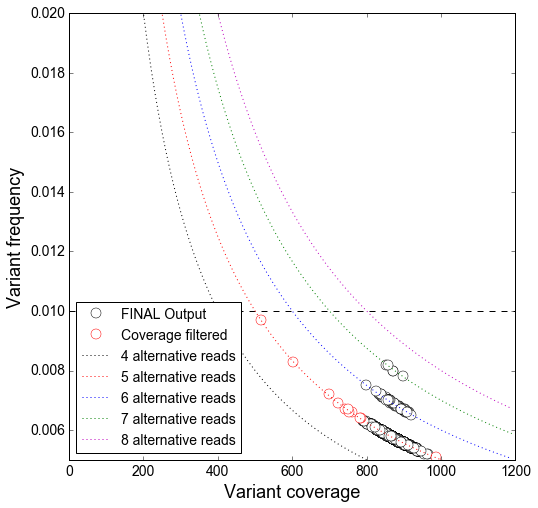

In [120]:
plt.figure(figsize=(8,8))
plt.plot(list(DF_ART[(DF_ART.STAGE=='FINAL')&(DF_ART.COVERAGE_CUT==0)].COVERAGE), 
         list(DF_ART[(DF_ART.STAGE=='FINAL')&(DF_ART.COVERAGE_CUT==0)].FREQUENCY), 
         'o', mfc='white', mec='black', ms=10, label='FINAL Output')

plt.plot(list(DF_ART[(DF_ART.STAGE=='FINAL')&(DF_ART.COVERAGE_CUT==1)].COVERAGE), 
         list(DF_ART[(DF_ART.STAGE=='FINAL')&(DF_ART.COVERAGE_CUT==1)].FREQUENCY), 
         'o', mfc='white', mec='red', ms=10, label='Coverage filtered')

plt.plot(np.arange(0,1200,10), 
         4/np.arange(0,1200,10), 
         'k:', label='4 alternative reads')

plt.plot(np.arange(0,1200,10), 
         5/np.arange(0,1200,10), 
         'r:', label='5 alternative reads')

plt.plot(np.arange(0,1200,10), 
         6/np.arange(0,1200,10), 
         'b:', label='6 alternative reads')

plt.plot(np.arange(0,1200,10), 
         7/np.arange(0,1200,10), 
         'g:', label='7 alternative reads')

plt.plot(np.arange(0,1200,10), 
         8/np.arange(0,1200,10), 
         'm:', label='8 alternative reads')

plt.legend(loc=3, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(0,1200)
#plt.yscale('log')
plt.ylim(0.005,0.02)
plt.hlines(0.01,0,1200, linestyles='dashed')

plt.xticks(size=14)
plt.yticks(size=14)

Looks promising. Let's check now for the colonies - using the kernel estimation for each sample, given that the coverage distributions look weird.

In [135]:
def Estimate_lambda(coverages):
    """Use kernel density estimation to identify
    maximum likelihood for the mean coverage.
    
    INPUTS:
    -------
    coverages: np.array-like, 1-d array of coverages
    
    OUTPUT:
    -------
    estimated_lambda: int
    
    NOTES:
    ------
    Needs scipy.stats as ss and numpy as np
    """
    
    _coverages = np.array(list(coverages))
    _max = max(_coverages)
    
    _kde = ss.kde.gaussian_kde(coverages)
    _kde_max = np.arange(_max)[np.argmax(_kde.pdf(np.arange(_max)))]
    
    return _kde_max

def Identify_coverage_cutoffs(coverages):
    """Determine coverage cutoffs.
    
    INPUTS:
    -------
    coverages: np.array-like, 1-d array of coverages
    
    OUTPUT:
    -------
    lower_co, upper_co: int
    
    NOTES:
    ------
    Needs scipy.stats as ss, numpy as np
    """
    
    _lambda = Estimate_lambda(coverages)
    
    _coverages = np.array(sorted(list(coverages)))
    _pois = np.array(sorted(ss.poisson(_lambda).rvs(len(_coverages),random_state=42)))
    
    _mean = np.mean(_coverages-_pois)
    _std = np.std(_coverages-_pois)
    
    _l, _u = _mean-_std, _mean+_std
    
    _uc = max(_coverages[np.where((_coverages-_pois)<_u)])
    _lc = min(_coverages[np.where((_coverages-_pois)>_l)])
    
    return _lc, _uc
    

In [146]:
COVERAGE_CUTOFFS = {}

for colony in ['76-K26', '76-K27', '91-K28', '91-K29']:
    coverages = list(DF_COLONY.COVERAGE[(DF_COLONY.STAGE=='BASIC')&(DF_COLONY.COLONY==colony)])
    lc, uc = Identify_coverage_cutoffs(coverages)
    COVERAGE_CUTOFFS[colony]={'LOWER':lc, 'UPPER':uc}
    
print(COVERAGE_CUTOFFS)

{'91-K29': {'UPPER': 1307, 'LOWER': 678}, '91-K28': {'UPPER': 1349, 'LOWER': 730}, '76-K27': {'UPPER': 1257, 'LOWER': 829}, '76-K26': {'UPPER': 1249, 'LOWER': 841}}


In [147]:
DF_COLONY['COVERAGE_CUT'] = [int(x<COVERAGE_CUTOFFS[y]['LOWER'] or x>COVERAGE_CUTOFFS[y]['UPPER'])\
                             for (x,y) in zip(DF_COLONY.COVERAGE, DF_COLONY.COLONY)]

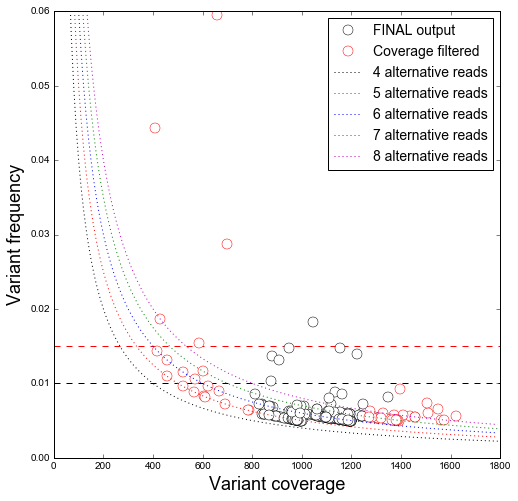

In [148]:
plt.figure(figsize=(8,8))
plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COVERAGE_CUT==0)].COVERAGE), 
         list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COVERAGE_CUT==0)].FREQUENCY), 
         'o', mfc='white', mec='black', ms=10, label='FINAL output')

plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COVERAGE_CUT==1)].COVERAGE), 
         list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.COVERAGE_CUT==1)].FREQUENCY), 
         'o', mfc='white', mec='red', ms=10, label='Coverage filtered')

plt.plot(np.arange(0,1800,10), 
         4/np.arange(0,1800,10), 
         'k:', label='4 alternative reads')

plt.plot(np.arange(0,1800,10), 
         5/np.arange(0,1800,10), 
         'r:', label='5 alternative reads')

plt.plot(np.arange(0,1800,10), 
         6/np.arange(0,1800,10), 
         'b:', label='6 alternative reads')

plt.plot(np.arange(0,1800,10), 
         7/np.arange(0,1800,10), 
         'g:', label='7 alternative reads')

plt.plot(np.arange(0,1800,10), 
         8/np.arange(0,1800,10), 
         'm:', label='8 alternative reads')

plt.legend(loc=0, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(0,1800)
#plt.yscale('log')
plt.ylim(0,0.06)
plt.hlines(0.01,0,1800, linestyles='dashed')
plt.hlines(0.015,0,1800, linestyles='dashed',colors='red')

I think this looks very promising, with minimal scientific assumptions...

(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.]),
 <a list of 10 Text yticklabel objects>)

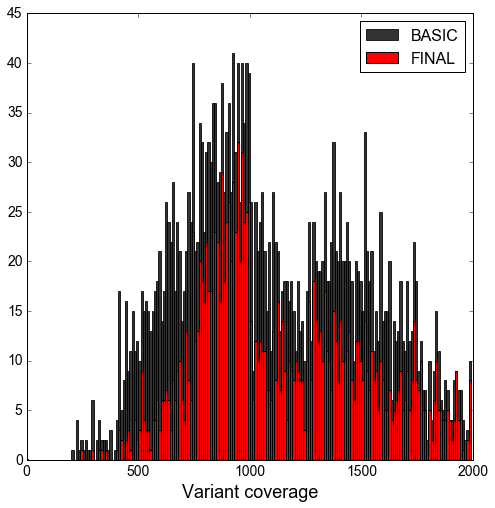

In [20]:
plt.figure(figsize=(8,8))
plt.hist(list(PATIENTS_BASIC.COVERAGE), 
         bins=np.arange(0,2000,10), color='black', 
         label='BASIC', alpha=0.8)
plt.hist(list(PATIENTS_FINAL.COVERAGE), 
         bins=np.arange(0,2000,10), color='red', 
         label='FINAL')
plt.legend(fontsize=16)
plt.xlabel('Variant coverage', size=18)
plt.xticks(size=14)
plt.yticks(size=14)


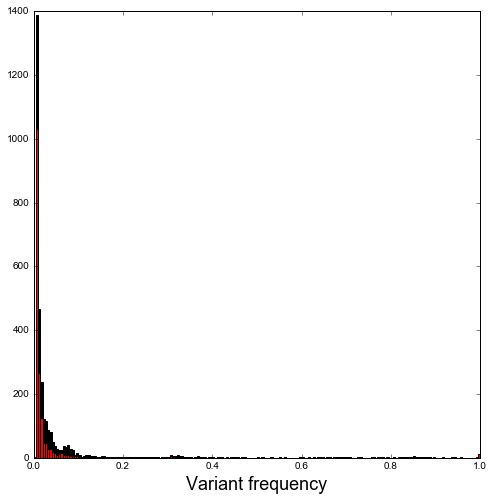

In [11]:
plt.figure(figsize=(8,8))
plt.hist(list(PATIENTS_BASIC.FREQUENCY), bins=np.arange(0,1.005,0.005), color='black')
plt.hist(list(PATIENTS_FINAL.FREQUENCY), bins=np.arange(0,1.005,0.005), color='red')
plt.xlabel('Variant frequency', size=18)

(array([   0.,   50.,  100.,  150.,  200.]),
 <a list of 5 Text yticklabel objects>)

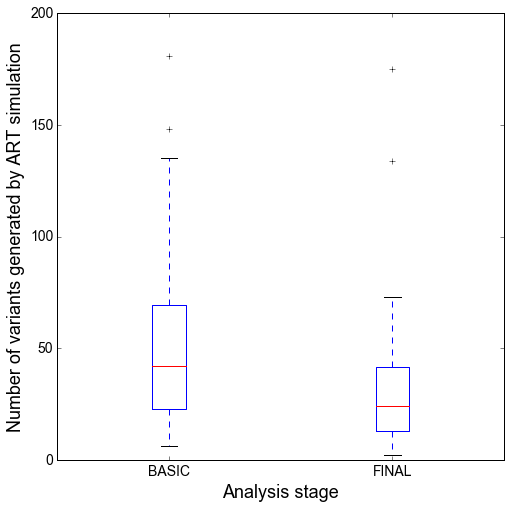

In [19]:
PATIENTS_BASIC['SAMPLE']=['{}{}'.format(x,y) for (x,y) in zip(PATIENTS_BASIC.PATIENT, PATIENTS_BASIC.TIME)]
PATIENTS_FINAL['SAMPLE']=['{}{}'.format(x,y) for (x,y) in zip(PATIENTS_FINAL.PATIENT, PATIENTS_FINAL.TIME)]

plt.figure(figsize=(8,8))
plt.boxplot([list(Counter(PATIENTS_BASIC.SAMPLE).values()),list(Counter(PATIENTS_FINAL.SAMPLE).values())])
plt.ylabel('Number of variants generated by ART simulation', size=18)
plt.xlabel('Analysis stage', size=18)
plt.xticks([1,2],['BASIC','FINAL'],size=14)
plt.yticks(size=14)

We're not losing as many any more. True variability?

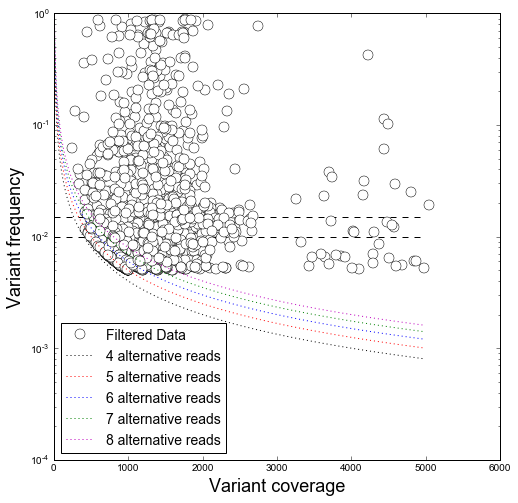

In [17]:
plt.figure(figsize=(8,8))
plt.plot(list(PATIENTS_FINAL.COVERAGE), 
         list(PATIENTS_FINAL.FREQUENCY), 
         'o', mfc='white', mec='black', ms=10, label='Filtered Data')

#plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.HIGH_VARIATION==1)].COVERAGE), 
#         list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.HIGH_VARIATION==1)].FREQUENCY), 
#         'o', mfc='white', mec='red', ms=10, label='High Variation')

plt.plot(np.arange(0,5000,10), 
         4/np.arange(0,5000,10), 
         'k:', label='4 alternative reads')

plt.plot(np.arange(0,5000,10), 
         5/np.arange(0,5000,10), 
         'r:', label='5 alternative reads')

plt.plot(np.arange(0,5000,10), 
         6/np.arange(0,5000,10), 
         'b:', label='6 alternative reads')

plt.plot(np.arange(0,5000,10), 
         7/np.arange(0,5000,10), 
         'g:', label='7 alternative reads')

plt.plot(np.arange(0,5000,10), 
         8/np.arange(0,5000,10), 
         'm:', label='8 alternative reads')

plt.legend(loc=0, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
#plt.yscale('log')
plt.hlines(0.01,0,5000, linestyles='dashed')
plt.hlines(0.015,0,5000, linestyles='dashed')
plt.yscale('log')

(0, 1)

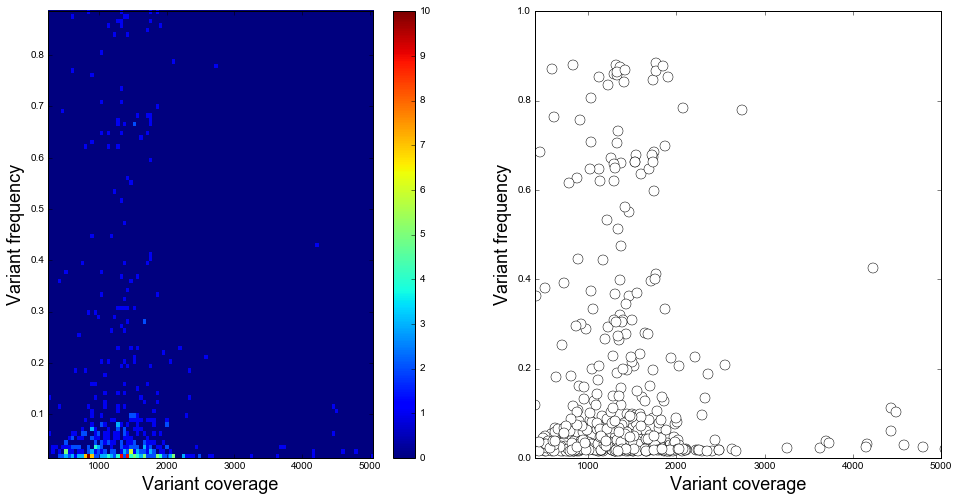

In [18]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.hist2d(list(PATIENTS_FINAL[(PATIENTS_FINAL.COVERAGE>0)&(PATIENTS_FINAL.FREQUENCY>0.015)].COVERAGE),
           list(PATIENTS_FINAL[(PATIENTS_FINAL.COVERAGE>0)&(PATIENTS_FINAL.FREQUENCY>0.015)].FREQUENCY), 100)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.colorbar()
plt.subplot(122)
plt.plot(list(PATIENTS_FINAL[(PATIENTS_FINAL.COVERAGE>0)&(PATIENTS_FINAL.FREQUENCY>0.015)].COVERAGE),
           list(PATIENTS_FINAL[(PATIENTS_FINAL.COVERAGE>0)&(PATIENTS_FINAL.FREQUENCY>0.015)].FREQUENCY), 
           'o', mfc='white', mec='black', ms=10)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(400,5000)
plt.ylim(0,1)

In [175]:
COVERAGE_CUTOFFS_PATIENTS = {}

for sample in list(set(PATIENTS_BASIC.SAMPLE)):
    coverages = list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.SAMPLE==sample)&(PATIENTS_BASIC.IN_FINAL==1)])
    lc, uc = Identify_coverage_cutoffs(coverages)
    COVERAGE_CUTOFFS_PATIENTS[sample]={'LOWER':lc, 'UPPER':uc}
    
print(COVERAGE_CUTOFFS_PATIENTS)

{'4908': {'UPPER': 1127, 'LOWER': 669}, '4100': {'UPPER': 1102, 'LOWER': 782}, '4906': {'UPPER': 1481, 'LOWER': 1171}, '3204': {'UPPER': 1467, 'LOWER': 1168}, '5100': {'UPPER': 1879, 'LOWER': 1335}, '40002A': {'UPPER': 1303, 'LOWER': 847}, '5216': {'UPPER': 1489, 'LOWER': 1063}, '2302': {'UPPER': 1198, 'LOWER': 961}, '2304': {'UPPER': 1855, 'LOWER': 1120}, '4108': {'UPPER': 1845, 'LOWER': 1422}, '5204': {'UPPER': 1435, 'LOWER': 1117}, '3304': {'UPPER': 1046, 'LOWER': 841}, '4008': {'UPPER': 1553, 'LOWER': 1016}, '2408': {'UPPER': 1195, 'LOWER': 878}, '3300': {'UPPER': 1062, 'LOWER': 751}, '5102': {'UPPER': 1009, 'LOWER': 729}, '1800': {'UPPER': 424, 'LOWER': 400}, '2404': {'UPPER': 1778, 'LOWER': 1330}, '4002': {'UPPER': 987, 'LOWER': 771}, '2300': {'UPPER': 1735, 'LOWER': 902}, '1802': {'UPPER': 1519, 'LOWER': 1044}, '1806': {'UPPER': 1401, 'LOWER': 1002}, '4904': {'UPPER': 1648, 'LOWER': 1108}, '2406': {'UPPER': 1704, 'LOWER': 1260}, '4016': {'UPPER': 1873, 'LOWER': 1279}, '5206': {'

In [176]:
PATIENTS_BASIC['COVERAGE_CUT'] = [int(x<COVERAGE_CUTOFFS_PATIENTS[y]['LOWER'] or x>COVERAGE_CUTOFFS_PATIENTS[y]['UPPER'])\
                             for (x,y) in zip(PATIENTS_BASIC.COVERAGE, PATIENTS_BASIC.SAMPLE)]

In [177]:
PATIENTS_BASIC['IN_FINAL'] = [int(x in list(PATIENTS_FINAL.LOCUS)) for x in PATIENTS_BASIC.LOCUS]
PATIENTS_BASIC['FREQ_CUT'] = [int(x<=0.015) for x in PATIENTS_BASIC.FREQUENCY]
PATIENTS_BASIC['CUT'] = [int(x+y>0) for (x,y) in zip(PATIENTS_BASIC.COVERAGE_CUT, 
                                                     PATIENTS_BASIC.FREQ_CUT)]

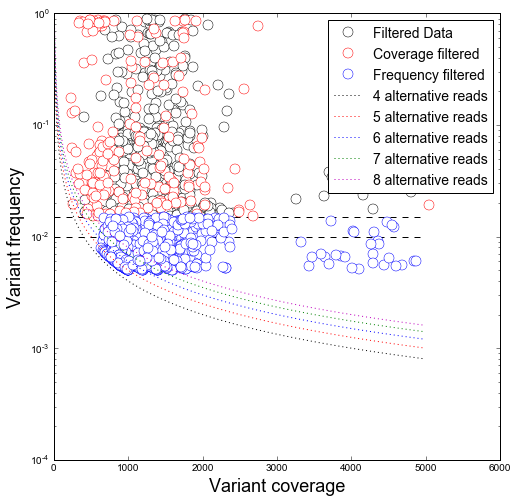

In [178]:
plt.figure(figsize=(8,8))
plt.plot(list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.COVERAGE_CUT==0)&\
                                      (PATIENTS_BASIC.FREQUENCY>0.015)]), 
         list(PATIENTS_BASIC.FREQUENCY[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.COVERAGE_CUT==0)&\
                                      (PATIENTS_BASIC.FREQUENCY>0.015)]), 
         'o', mfc='white', mec='black', ms=10, label='Filtered Data')

plt.plot(list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.COVERAGE_CUT==1)&\
                                      (PATIENTS_BASIC.FREQUENCY>0.015)]), 
         list(PATIENTS_BASIC.FREQUENCY[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.COVERAGE_CUT==1)&\
                                      (PATIENTS_BASIC.FREQUENCY>0.015)]), 
         'o', mfc='white', mec='red', ms=10, label='Coverage filtered')

plt.plot(list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.COVERAGE_CUT==0)&\
                                      (PATIENTS_BASIC.FREQUENCY<=0.015)]), 
         list(PATIENTS_BASIC.FREQUENCY[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.COVERAGE_CUT==0)&\
                                      (PATIENTS_BASIC.FREQUENCY<=0.015)]), 
         'o', mfc='white', mec='blue', ms=10, label='Frequency filtered')

#plt.plot(list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.HIGH_VARIATION==1)].COVERAGE), 
#         list(DF_COLONY[(DF_COLONY.STAGE=='FINAL')&(DF_COLONY.HIGH_VARIATION==1)].FREQUENCY), 
#         'o', mfc='white', mec='red', ms=10, label='High Variation')

plt.plot(np.arange(0,5000,10), 
         4/np.arange(0,5000,10), 
         'k:', label='4 alternative reads')

plt.plot(np.arange(0,5000,10), 
         5/np.arange(0,5000,10), 
         'r:', label='5 alternative reads')

plt.plot(np.arange(0,5000,10), 
         6/np.arange(0,5000,10), 
         'b:', label='6 alternative reads')

plt.plot(np.arange(0,5000,10), 
         7/np.arange(0,5000,10), 
         'g:', label='7 alternative reads')

plt.plot(np.arange(0,5000,10), 
         8/np.arange(0,5000,10), 
         'm:', label='8 alternative reads')

plt.legend(loc=0, fontsize=14)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
#plt.yscale('log')
plt.hlines(0.01,0,5000, linestyles='dashed')
plt.hlines(0.015,0,5000, linestyles='dashed')
plt.yscale('log')

(0, 1)

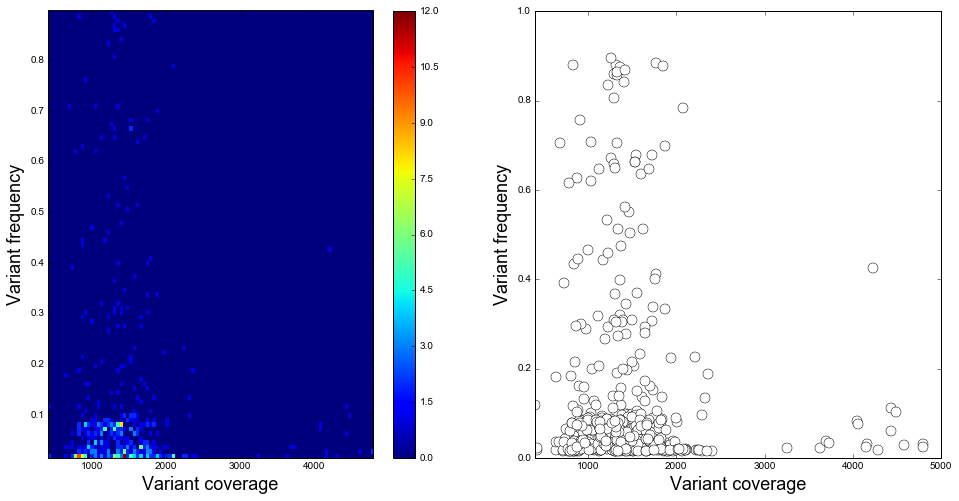

In [179]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.hist2d(list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.CUT==0)]),
           list(PATIENTS_BASIC.FREQUENCY[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.CUT==0)]), 100)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.colorbar()
plt.subplot(122)
plt.plot(list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.CUT==0)]),
           list(PATIENTS_BASIC.FREQUENCY[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.CUT==0)]), 
           'o', mfc='white', mec='black', ms=10)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(400,5000)
plt.ylim(0,1)

(0, 1)

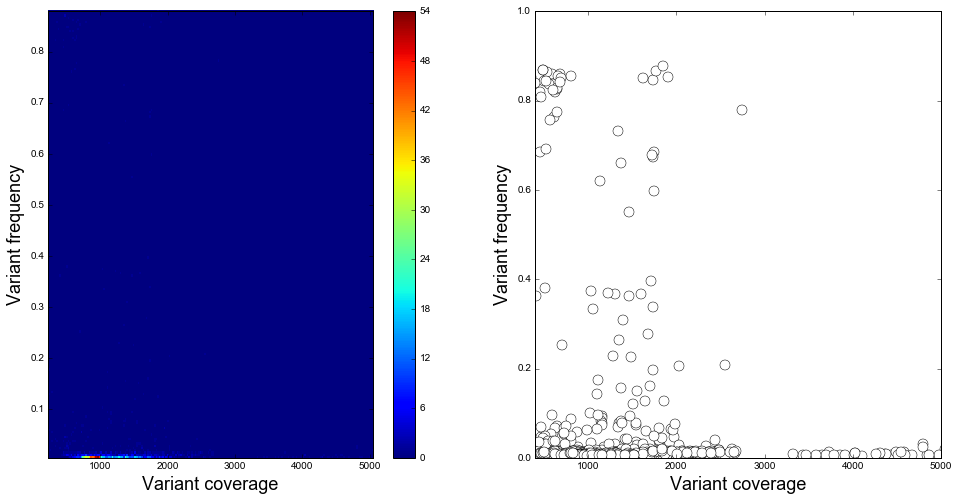

In [169]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.hist2d(list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.CUT==1)]),
           list(PATIENTS_BASIC.FREQUENCY[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.CUT==1)]), 200)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.colorbar()
plt.subplot(122)
plt.plot(list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.CUT==1)]),
           list(PATIENTS_BASIC.FREQUENCY[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.CUT==1)]), 
           'o', mfc='white', mec='black', ms=10)
plt.ylabel('Variant frequency', size=18)
plt.xlabel('Variant coverage', size=18)
plt.xlim(400,5000)
plt.ylim(0,1)

In [180]:
len(list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.CUT==1)]))

1550

In [181]:
len(list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.CUT==0)]))

506

In [182]:
len(list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&\
                                      (PATIENTS_BASIC.FREQ_CUT==1)]))

1357

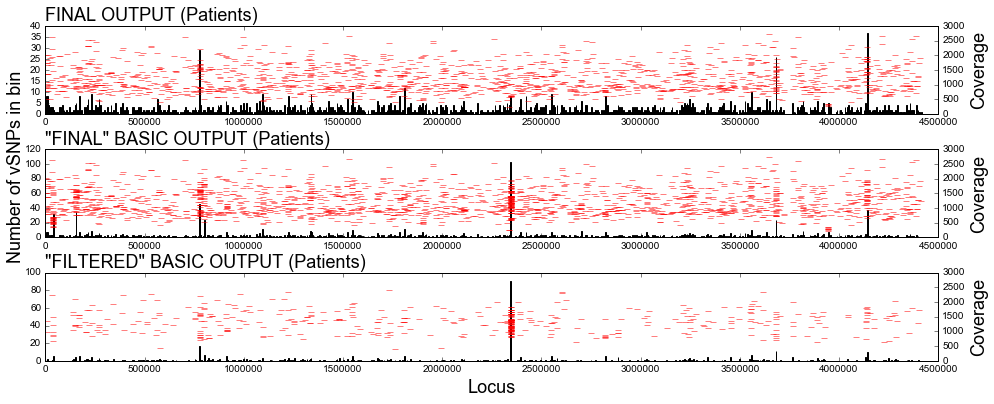

In [188]:
plt.figure(figsize=(16,6))
plt.subplot(311)
plt.title('FINAL OUTPUT (Patients)', loc='left', size=18)
plt.hist(list(PATIENTS_FINAL.LOCUS), bins=np.arange(0,4.5e6,4000), color='black')
plt.ylabel('Number of vSNPs in bin', size=18, horizontalalignment='right')
plt.twinx()
plt.plot(list(PATIENTS_FINAL.LOCUS), 
         list(PATIENTS_FINAL.COVERAGE), 'r_')
plt.ylim(0,3000)
plt.ylabel('Coverage', size=18)
plt.subplot(312)
plt.title('"FINAL" BASIC OUTPUT (Patients)', loc='left', size=18)
plt.hist(list(PATIENTS_BASIC.LOCUS[(PATIENTS_BASIC.IN_FINAL==1)]), bins=np.arange(0,4.5e6,4000), color='black')
plt.twinx()
plt.plot(list(PATIENTS_BASIC.LOCUS[(PATIENTS_BASIC.IN_FINAL==1)]), 
         list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)]), 'r_')
plt.ylim(0,3000)
plt.ylabel('Coverage', size=18)

plt.subplot(313)
plt.title('"FILTERED" BASIC OUTPUT (Patients)', loc='left', size=18)
plt.hist(list(PATIENTS_BASIC.LOCUS[(PATIENTS_BASIC.IN_FINAL==1)&(PATIENTS_BASIC.CUT==0)]), bins=np.arange(0,4.5e6,4000), color='black')
plt.xlabel('Locus', size=18)
plt.twinx()
plt.plot(list(PATIENTS_BASIC.LOCUS[(PATIENTS_BASIC.IN_FINAL==1)&(PATIENTS_BASIC.CUT==0)]), 
         list(PATIENTS_BASIC.COVERAGE[(PATIENTS_BASIC.IN_FINAL==1)&(PATIENTS_BASIC.CUT==0)]), 'r_')
plt.ylim(0,3000)
plt.ylabel('Coverage', size=18)

plt.subplots_adjust(hspace=0.4)

There's something odd going on here. It seems that there are SNPs in FINAL that are filtered from some patients but not others. 

Either way though, looks like the coverage filter may not effectively do what I want it to do... e.g. the big peak at 2.4M or so... So, bottom line: <strong>STICK TO FREQUENCY CUTOFF</strong>